# Dev Day 1

Main goals:
- Get working on toy models of superpos

Tasks:
- runner
- set 
- train loop
- wandb
- dataloader

In [1]:
import torch 
import transformer_lens
import wandb


In [2]:


cfg = {
    # Data Generating function
    "model_name": "gelu-2l", # Valid TransformerLens model
    "hook_point": "blocks.0.hook_mlp_out", # Hook point in the model
    "hook_point_layer": 0, # Layer number of the hook point
    "dataset_path": "NeelNanda/c4-tokenized-2b", # Dataset path
    
    # SAE
    "expansion_factor": 4, # SAE Expansion Factor
    
    # Training cfg
    "l1_coefficient": 1e-3, # L1 coefficient is the coefficient of the L1 regularization term (used to encourage sparsity).
    "lr": 3e-4, # Learning Rate
    "train_batch_size": 4096,
    "context_size": 128,

    # Activation Store
    "max_store_size": 384 * 4096 * 2,
    "max_activations": 2_000_000_000,
    "resample_frequency": 122_880_000,
    "checkpoint_frequency": 100_000_000, 
    "validation_frequency": 384 * 4096 * 2 * 100,  # Every 100 generations
    
    # Wandb
    "log_to_wandb": True,
    "wandb_project": "mats_sae_training",
    "wandb_entity": None, 
    
    # Other details
    "device": "cpu",
    "seed": 42,
    "checkpoint_path": "checkpoints",
    "dtype": torch.float32,
}

- Load from pretrained
- Get hooks 
- SAE Model 
- Initialize the optimizer
- Load Hugging Face Model
- Activation Store



Dataset options

GenericTextDataset should work with the following datasets:
- monology/pile-uncopyrighted
- the_pile_openwebtext2
- roneneldan/TinyStories-33M
- roneneldan/TinyStories-8M
- roneneldan/TinyStories-3M
- roneneldan/TinyStories-1Layer-21M
- roneneldan/TinyStories-1M
- roneneldan/TinyStories-2Layers-33M
- roneneldan/TinyStories-Instruct-2Layers-33M
- roneneldan/TinyStories-Instruct-28M
- roneneldan/TinyStories-Instruct-33M
- roneneldan/TinyStories-Instruct-8M
- roneneldan/TinyStories-Instruct-3M
- roneneldan/TinyStories-Instruct-1M
- roneneldan/TinyStories-Instuct-1Layer-21M
- roneneldan/TinyStories-28M
"""

Pretokenized options
- NeelNanda/pile-small-tokenized-2b
- NeelNanda/pile-tokenized-10b
- NeelNanda/openwebtext-tokenized-9b
- NeelNanda/c4-tokenized-2b
- NeelNanda/code-tokenized
- NeelNanda/c4-code-tokenized-2b
- NeelNanda/pile-old-tokenized-2b

In [3]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("gelu-2l") # any other cfg we should pass in here?
hook_point_options = [i for i,_ in model.named_modules() if "hook" in i]

Loaded pretrained model gelu-2l into HookedTransformer


In [4]:
from datasets import IterableDataset, load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset



# To do: preprocess_tokenized_dataset, preprocess_text_dataset, preprocess other dataset
def preprocess_tokenized_dataset(source_batch: dict, context_size: int) -> dict:
    tokenized_prompts = source_batch["tokens"]

    # Chunk each tokenized prompt into blocks of context_size,
    # discarding the last block if too small.
    context_size_prompts = []
    for encoding in tokenized_prompts:
        chunks = [
            encoding[i : i + context_size]
            for i in range(0, len(encoding), context_size)
            if len(encoding[i : i + context_size]) == context_size
        ]
        context_size_prompts.extend(chunks)

    return {"input_ids": context_size_prompts}


def get_mapped_dataset(cfg):
    # Load the dataset
    context_size = cfg["context_size"]
    dataset_path = cfg["dataset_path"]
    dataset_split = "train"
    buffer_size: int = 1000,
    preprocess_batch_size: int = 1000,

    dataset = load_dataset(dataset_path, streaming=True, split=dataset_split)  # type: ignore

    # Setup preprocessing
    existing_columns = list(next(iter(dataset)).keys())
    mapped_dataset = dataset.map(
        preprocess_tokenized_dataset, # preprocess is what differentiates different datasets
        batched=True,
        batch_size=preprocess_batch_size,
        fn_kwargs={"context_size": context_size},
        remove_columns=existing_columns,
    )

    # Setup approximate shuffling. As the dataset is streamed, this just pre-downloads at least
    # `buffer_size` items and then shuffles just that buffer.
    # https://huggingface.co/docs/datasets/v2.14.5/stream#shuffle
    dataset = mapped_dataset.shuffle(buffer_size=buffer_size)
    return dataset

dataset = get_mapped_dataset(cfg)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [5]:
type(dataset)

datasets.iterable_dataset.IterableDataset

Need to support different types of datasets
- Lists [ ]
- Tensor [ ]
-  Disk [x]

In [6]:
from src.SAE import SAE

cfg["d_in"] = 768 # can we automatically get the d_in?
cfg["d_sae"] = cfg["d_in"]  * cfg["expansion_factor"] # can we automatically get the d_sae?
SAE(cfg)

SAE(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

In [7]:
from src.SAE import SAE
# from src.train_sae import train_sae



class ActivationStore():
    
    def __init__(self, cfg, dataset):
        self.cfg = cfg
        self.dataset = dataset
        
        

def train_sae(sparse_autoencoder: SAE,
              activation_store: ActivationStore,
              n_epochs: int = 10,
              batch_size: int = 32,
              l1_coeff: float = 0.0001):
    
    return sparse_autoencoder
        
def sae_training_runner(cfg):
    
    # intialize wandb session
    # wandb.init(project=cfg["wandb_project"], entity=cfg["wandb_entity"], config=cfg)
    
    # initialize model
    model_name = cfg["model_name"]
    model = HookedTransformer.from_pretrained(model_name) # any other cfg we should pass in here?
    
    # initialize dataset
    dataset = get_mapped_dataset(cfg)
    activation_store = ActivationStore(cfg, dataset)
    
    # initialize the SAE
    sparse_autoencoder = SAE(cfg)
    
    # train SAE
    sparse_autoencoder = train_sae(
        model, 
        activation_store, 
        sparse_autoencoder, 
        cfg)
    
    
    return sparse_autoencoder

sae_training_runner(cfg)

Loaded pretrained model gelu-2l into HookedTransformer


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hoo

# Get a Toy Model Trained so we can test the SAE

Get the Toy Model of Superposition

In [10]:
from dataclasses import dataclass
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from torch import nn, Tensor
import torch as t 
from tqdm import tqdm
import einops
from torch.nn import functional as F

device = "cpu"

def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0

class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    # def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
    #     '''
    #     Generates a batch of data. We'll return to this function later when we apply correlations.
    #     '''
    #     feat = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
    #     feat_seeds = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
    #     feat_is_present = feat_seeds <= self.feature_probability
    #     batch = t.where(
    #         feat_is_present,
    #         feat,
    #         t.zeros((), device=self.W.device),
    #     )
    #     return batch

    def generate_correlated_features(self, batch_size, n_correlated_pairs) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of correlated features.
        Each output[i, j, 2k] and output[i, j, 2k + 1] are correlated, i.e. one is present iff the other is present.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, 2 * n_correlated_pairs), device=self.W.device)
        feat_set_seeds = t.rand((batch_size, self.cfg.n_instances, n_correlated_pairs), device=self.W.device)
        feat_set_is_present = feat_set_seeds <= self.feature_probability[:, [0]]
        feat_is_present = einops.repeat(feat_set_is_present, "batch instances features -> batch instances (features pair)", pair=2)
        return t.where(feat_is_present, feat, 0.0)

    def generate_anticorrelated_features(self, batch_size, n_anticorrelated_pairs) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of anti-correlated features.
        Each output[i, j, 2k] and output[i, j, 2k + 1] are anti-correlated, i.e. one is present iff the other is absent.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, 2 * n_anticorrelated_pairs), device=self.W.device)
        feat_set_seeds = t.rand((batch_size, self.cfg.n_instances, n_anticorrelated_pairs), device=self.W.device)
        first_feat_seeds = t.rand((batch_size, self.cfg.n_instances, n_anticorrelated_pairs), device=self.W.device)
        feat_set_is_present = feat_set_seeds <= 2 * self.feature_probability[:, [0]]
        first_feat_is_present = first_feat_seeds <= 0.5
        first_feats = t.where(feat_set_is_present & first_feat_is_present, feat[:, :, :n_anticorrelated_pairs], 0.0)
        second_feats = t.where(feat_set_is_present & (~first_feat_is_present), feat[:, :, n_anticorrelated_pairs:], 0.0)
        return einops.rearrange(t.concat([first_feats, second_feats], dim=-1), "batch instances (pair features) -> batch instances (features pair)", pair=2)
    
    def generate_uncorrelated_features(self, batch_size, n_uncorrelated) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of uncorrelated features.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, n_uncorrelated), device=self.W.device)
        feat_seeds = t.rand((batch_size, self.cfg.n_instances, n_uncorrelated), device=self.W.device)
        feat_is_present = feat_seeds <= self.feature_probability[:, [0]]
        return t.where(feat_is_present, feat, 0.0)
    
    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data, with optional correlated & anticorrelated features.
        '''
        n_uncorrelated = self.cfg.n_features - 2 * self.cfg.n_correlated_pairs - 2 * self.cfg.n_anticorrelated_pairs
        data = []
        if self.cfg.n_correlated_pairs > 0:
            data.append(self.generate_correlated_features(batch_size, self.cfg.n_correlated_pairs))
        if self.cfg.n_anticorrelated_pairs > 0:
            data.append(self.generate_anticorrelated_features(batch_size, self.cfg.n_anticorrelated_pairs))
        if n_uncorrelated > 0:
            data.append(self.generate_uncorrelated_features(batch_size, n_uncorrelated))
        batch = t.cat(data, dim=-1)
        return batch




    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `model.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        '''
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
        return loss


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))
        
        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr
            
            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


cfg = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)
model = Model(
    cfg = cfg,
    device = "cpu",
    feature_probability = 0.025,
)
model.optimize(steps=10_000)

# plot_features_in_2d(
#     values = model.W.detach(),
#     title = "Superposition: 5 features represented in 2D space",
# )

batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")


  0%|          | 0/10000 [00:00<?, ?it/s, loss=0.00691, lr=0.001]

100%|██████████| 10000/10000 [00:19<00:00, 502.31it/s, loss=0.000719, lr=0.001]


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


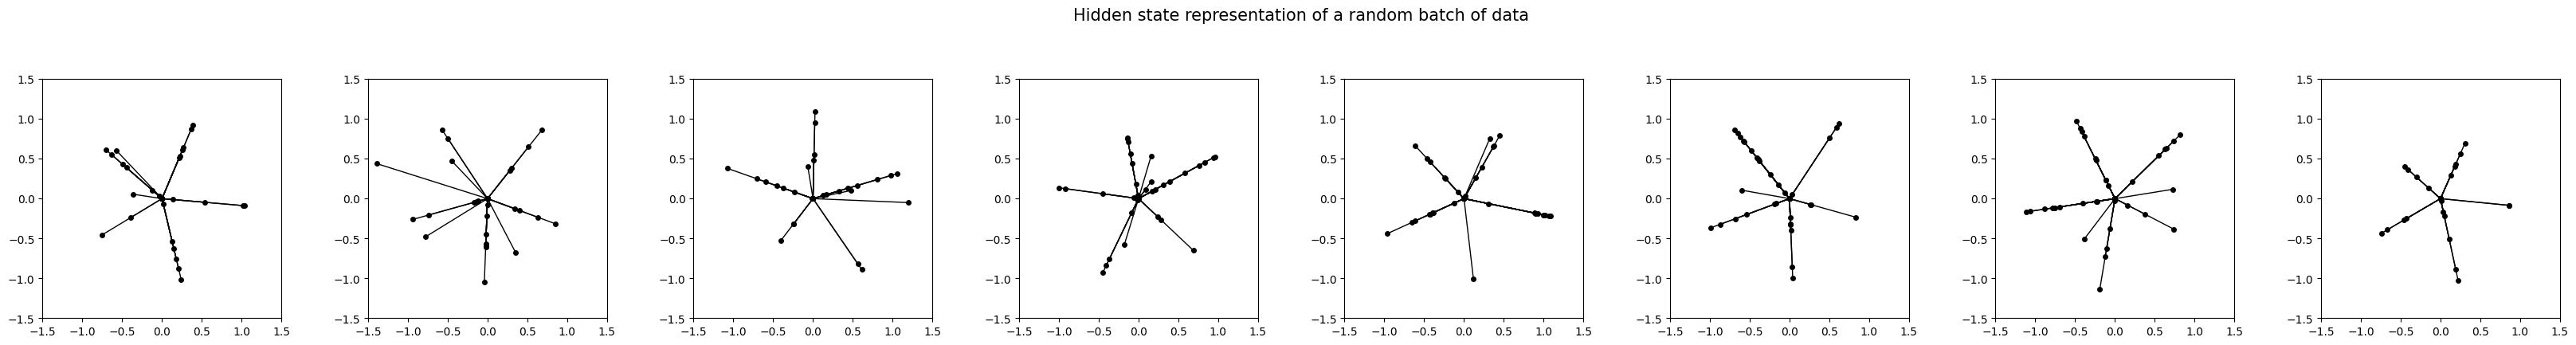

In [11]:
import torch as t
from torch import Tensor
from IPython.display import clear_output
from typing import List, Union, Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from typing import Tuple, List
from jaxtyping import Float
import einops

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider # , Button
from matplotlib.animation import FuncAnimation

Arr = np.ndarray


def plot_features_in_2d(
    values: Float[Tensor, "timesteps instances d_hidden feats"],
    colors = None, # shape [timesteps instances feats]
    title: Optional[str] = None,
    subplot_titles: Optional[List[str]] = None,
    save: Optional[str] = None,
    colab: bool = False,
):
    '''
    Visualises superposition in 2D.

    If values is 4D, the first dimension is assumed to be timesteps, and an animation is created.
    '''
    # Convert values to 4D for consistency
    if values.ndim == 3:
        values = values.unsqueeze(0)
    values = values.transpose(-1, -2)
    
    # Get dimensions
    n_timesteps, n_instances, n_features, _ = values.shape

    # If we have a large number of features per plot (i.e. we're plotting projections of data) then use smaller lines
    linewidth, markersize = (1, 4) if (n_features >= 25) else (2, 10)
    
    # Convert colors to 3D, if it's 2D (i.e. same colors for all instances)
    if isinstance(colors, list) and isinstance(colors[0], str):
        colors = [colors for _ in range(n_instances)]
    # Convert colors to something which has 4D, if it is 3D (i.e. same colors for all timesteps)
    if any([
        colors is None,
        isinstance(colors, list) and isinstance(colors[0], list) and isinstance(colors[0][0], str),
        (isinstance(colors, Tensor) or isinstance(colors, Arr)) and colors.ndim == 3,
    ]):
        colors = [colors for _ in range(values.shape[0])]
    # Now that colors has length `timesteps` in some sense, we can convert it to lists of strings
    colors = [parse_colors_for_superposition_plot(c, n_instances, n_features) for c in colors]

    # Same for subplot titles & titles
    if subplot_titles is not None:
        if isinstance(subplot_titles, list) and isinstance(subplot_titles[0], str):
            subplot_titles = [subplot_titles for _ in range(values.shape[0])]
    if title is not None:
        if isinstance(title, str):
            title = [title for _ in range(values.shape[0])]

    # Create a figure and axes
    fig, axs = plt.subplots(1, n_instances, figsize=(5 * n_instances, 5))
    if n_instances == 1:
        axs = [axs]
    
    # If there are titles, add more spacing for them
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)
    if title:
        fig.subplots_adjust(top=0.8)
    # Initialize lines and markers
    lines = []
    markers = []
    for instance_idx, ax in enumerate(axs):
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal', adjustable='box')
        instance_lines = []
        instance_markers = []
        for feature_idx in range(n_features):
            line, = ax.plot([], [], color=colors[0][instance_idx][feature_idx], lw=linewidth)
            marker, = ax.plot([], [], color=colors[0][instance_idx][feature_idx], marker='o', markersize=markersize)
            instance_lines.append(line)
            instance_markers.append(marker)
        lines.append(instance_lines)
        markers.append(instance_markers)

    def update(val):
        # I think this doesn't work unless I at least reference the nonlocal slider object
        # It works if I use t = int(val), so long as I put something like X = slider.val first. Idk why!
        if n_timesteps > 1:
            _ = slider.val
        t = int(val) 
        for instance_idx in range(n_instances):
            for feature_idx in range(n_features):
                x, y = values[t, instance_idx, feature_idx].tolist()
                lines[instance_idx][feature_idx].set_data([0, x], [0, y])
                markers[instance_idx][feature_idx].set_data(x, y)
                lines[instance_idx][feature_idx].set_color(colors[t][instance_idx][feature_idx])
                markers[instance_idx][feature_idx].set_color(colors[t][instance_idx][feature_idx])
            if title:
                fig.suptitle(title[t], fontsize=15)
            if subplot_titles:
                axs[instance_idx].set_title(subplot_titles[t][instance_idx], fontsize=12)
        fig.canvas.draw_idle()
    def play(event):
        _ = slider.val
        for i in range(n_timesteps):
            update(i)
            slider.set_val(i)
            plt.pause(0.05)
        fig.canvas.draw_idle()

    if n_timesteps > 1:
        # Create the slider
        ax_slider = plt.axes([0.15, 0.05, 0.7, 0.05], facecolor='lightgray')
        slider = Slider(ax_slider, 'Time', 0, n_timesteps - 1, valinit=0, valfmt='%1.0f')

        # Create the play button
        # ax_button = plt.axes([0.8, 0.05, 0.08, 0.05], facecolor='lightgray')
        # button = Button(ax_button, 'Play')

        # Call the update function when the slider value is changed / button is clicked
        slider.on_changed(update)
        # button.on_clicked(play)

        # Initialize the plot
        play(0)
    else:
        update(0)

    # Save
    if isinstance(save, str):
        ani = FuncAnimation(fig, update, frames=n_timesteps, interval=0.04, repeat=False)
        ani.save(save, writer='pillow', fps=25)
    elif colab:
        ani = FuncAnimation(fig, update, frames=n_timesteps, interval=0.04, repeat=False)
        clear_output()
        return ani
    


def parse_colors_for_superposition_plot(
    colors: Optional[Union[Tuple[int, int], Float[Tensor, "instances feats"]]],
    n_instances: int,
    n_feats: int,
) -> List[List[str]]:
    '''
    There are lots of different ways colors can be represented in the superposition plot.
    
    This function unifies them all by turning colors into a list of lists of strings, i.e. one color for each instance & feature.
    '''
    # If colors is a tensor, we assume it's the importances tensor, and we color according to a viridis color scheme
    if isinstance(colors, Tensor):
        colors = t.broadcast_to(colors, (n_instances, n_feats))
        colors = [
            [helper_get_viridis(v.item()) for v in colors_for_this_instance]
            for colors_for_this_instance in colors
        ]
    
    # If colors is a tuple of ints, it's interpreted as number of correlated / anticorrelated pairs
    elif isinstance(colors, tuple):
        n_corr, n_anti = colors
        n_indep = n_feats - 2 * (n_corr - n_anti)
        colors = [
            ["blue", "blue", "limegreen", "limegreen", "purple", "purple"][:n_corr*2] + ["red", "red", "orange", "orange", "brown", "brown"][:n_anti*2] + ["black"] * n_indep
            for _ in range(n_instances)
        ]
    
    # If colors is a string, make all datapoints that color
    elif isinstance(colors, str):
        colors = [[colors] * n_feats] * n_instances
    
    # Lastly, if colors is None, make all datapoints black
    elif colors is None:
        colors = [["black"] * n_feats] * n_instances
    
    return colors



plot_features_in_2d(
    values = hidden,
    title = "Hidden state representation of a random batch of data",
)


Train the SAE

In [12]:
from torch.distributions.categorical import Categorical

@dataclass
class AutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    l1_coeff: float = 1.0
    tied_weights: bool = False


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: AutoEncoderConfig):
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))
        self.to(device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).sum(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum() # scalar
        
        return l1_loss, l2_loss, loss, acts, h_reconstructed
    
    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm. If using tied weights, we we assume W_enc is used for both.
        '''
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        _, l2_loss, _, _, _ = self.forward(h)

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_neurons_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_neurons_mask[instance] = is_dead
            dead_neurons = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_neurons.numel()
            if n_dead == 0: continue
            
            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance] # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue # If we have zero reconstruction loss, we don't need to resample neurons
            
            # Draw `n_hidden_ae` samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance / l2_loss_instance.sum())
            replacement_indices = distn.sample((n_dead,)) # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance] # shape [n_dead n_input_ae]

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()
            
            # Use this to renormalize the replacement values
            replacement_values = (replacement_values / (replacement_values.norm(dim=1, keepdim=True) + 1e-8)) * W_enc_norm_alive_mean * neuron_resample_scale

            # Lastly, set the new weights & biases
            self.W_enc.data[instance, :, dead_neurons] = replacement_values.T
            self.b_enc.data[instance, dead_neurons] = 0.0

        # Return data for visualising the resampling process
        colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_neurons_mask]
        title = f"resampling {dead_neurons_mask.sum().item()}/{dead_neurons_mask.numel()} neurons (shown in red)"
        return colors, title

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))
        
        # Create lists to store data we'll eventually be plotting
        data_log = {"values": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")
            
            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()
            
            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["values"].append(self.W_enc.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log
    
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.5,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
)

100%|██████████| 36000/36000 [01:31<00:00, 393.91it/s, l1_loss=0.352, l2_loss=0.0845, lr=0.001]


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


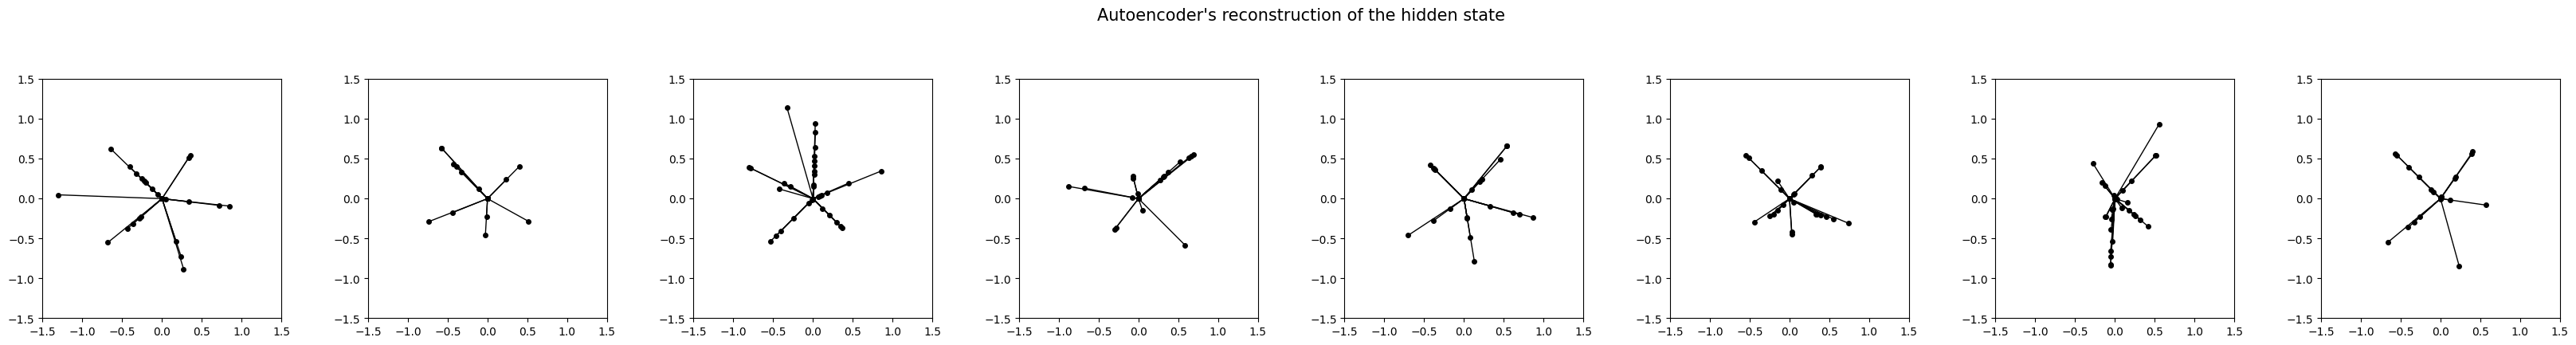

In [13]:
# Now check the points are being reconstructed faithfully by our autoencoder
batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed = autoencoder.forward(hidden)[-1]

plot_features_in_2d(
    values = einops.rearrange(hidden_reconstructed, "batch_size instances hidden -> instances hidden batch_size"),
    title = "Autoencoder's reconstruction of the hidden state",
)


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


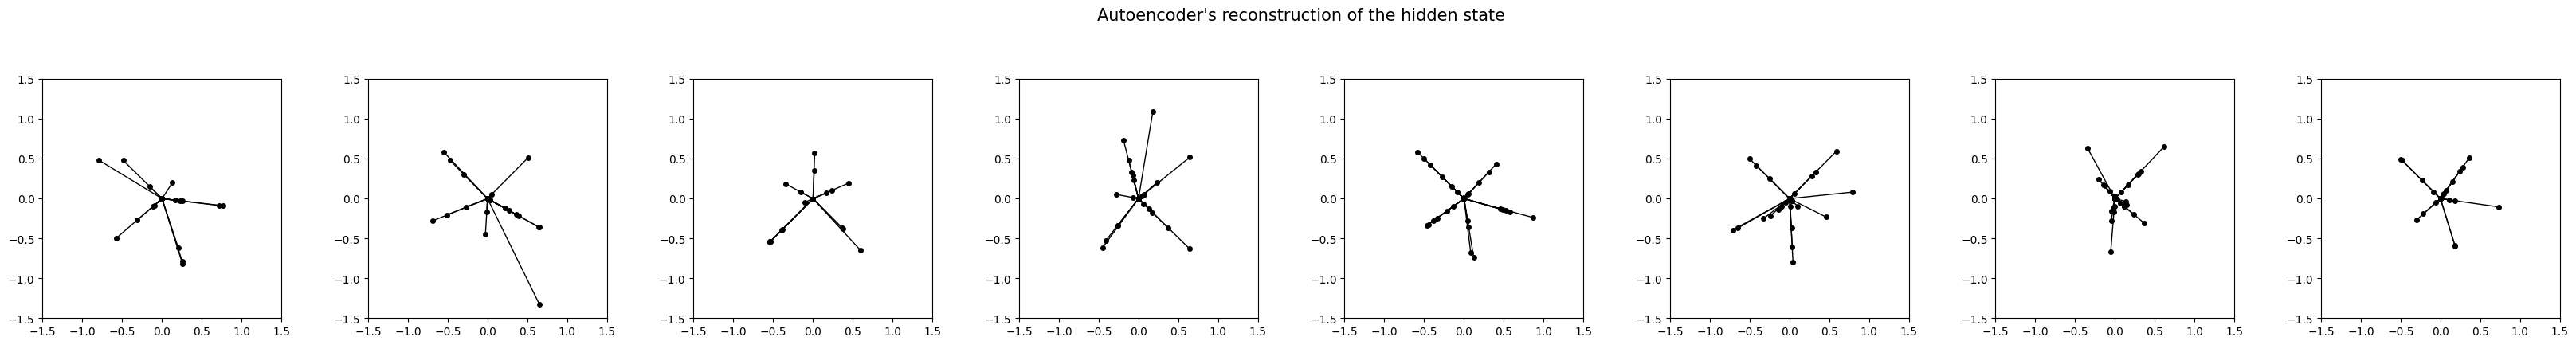

In [14]:
# Now check the points are being reconstructed faithfully by our autoencoder
batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed = autoencoder.forward(hidden)[-1]

plot_features_in_2d(
    values = einops.rearrange(hidden_reconstructed, "batch_size instances hidden -> instances hidden batch_size"),
    title = "Autoencoder's reconstruction of the hidden state",
)

In [15]:
batch.shape

torch.Size([250, 8, 5])

In [16]:
hidden.shape

torch.Size([250, 8, 2])

In [17]:
#%%
import torch
from torch.utils.data import DataLoader
import einops
import wandb
from src.SAE import SAE
from src.activation_store import ActivationStore

#%%
def train_sae(sae: SAE,
              activation_store: ActivationStore,
              n_epochs: int = 10,
              batch_size: int = 32,
              l1_coeff: float = 0.0001,
              use_wandb: bool = False):
    """
        Takes an SAE and a bunch of activations and does a bunch of training steps
    """
    
    dataloader = DataLoader(activation_store, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(sae.parameters())
    
    for _ in range(n_epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            
            sae_out, hidden_post = sae(batch)
            # loss = reconstruction MSE + L1 regularization
            mse_loss = ((sae_out - batch)**2).mean()
            l1_loss = torch.abs(hidden_post).sum()
            loss = mse_loss + l1_coeff * l1_loss

            with torch.no_grad():
                batch_size = batch.shape[0]
                feature_mean_activation = hidden_post.mean(dim=0)
                n_dead_features = (feature_mean_activation == 0).sum().item()
                if use_wandb:
                    wandb.log({
                        "mse_loss": mse_loss.item(),
                        "l1_loss": l1_loss.item(),
                        "loss": loss.item(),
                        "l0": ((hidden_post != 0) / batch_size).sum().item(),
                        "l2": torch.norm(hidden_post, dim=1).mean().item(),
                        "hist": wandb.Histogram(feature_mean_activation.tolist()),
                        "n_dead_features": n_dead_features,
                    })
            
            loss.backward()
            
            # Taken from Artur's code https://github.com/ArthurConmy/sae/blob/3f8c314d9c008ec40de57828762ec5c9159e4092/sae/utils.py#L91
            # TODO do we actually need this?
            # Update grads so that they remove the parallel component
            # (d_sae, d_in) shape
            # with torch.no_grad():
            #     parallel_component = einops.einsum(
            #         sae.W_dec.grad,
            #         sae.W_dec.data,
            #         "d_sae d_in, d_sae d_in -> d_sae",
            #     )
            #     sae.W_dec.grad -= einops.einsum(
            #         parallel_component,
            #         sae.W_dec.data,
            #         "d_sae, d_sae d_in -> d_sae d_in",
            #     )
            
            optimizer.step()
            
            # Make sure the W_dec is still zero-norm
            # with torch.no_grad():
            #     sae.W_dec.data /= (torch.norm(sae.W_dec.data, dim=1, keepdim=True) + 1e-8)


In [20]:
from src.SAE import SAE

sae_cfg = {
    "d_in": 2,
    "d_sae": 5,
    "dtype": t.float32,
    "device": "cpu",
}
sae = SAE(sae_cfg)

sae.train()

wandb.init()
train_sae(sae, hidden.detach(), )

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x30dc7dc90>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 30bd804c0, raw_cell="from src.SAE import SAE

sae_cfg = {
    "d_in": 2.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/tz20913/Library/Mobile%20Documents/com~apple~CloudDocs/Desktop/Research/MATS_Neel/mats_sae_training/dev.ipynb#X31sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from src.SAE import SAE

cfg["d_in"] = 768 # can we automatically get the d_in?
cfg["d_sae"] = cfg["d_in"]  * cfg["expansion_factor"] # can we automatically get the d_sae?
SAE(cfg)

SAE(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

# Get a Toy Model Trained so we can test the SAE

Get the Toy Model of Superposition

100%|██████████| 10000/10000 [00:03<00:00, 2803.45it/s, loss=0.000433, lr=0.001]
/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


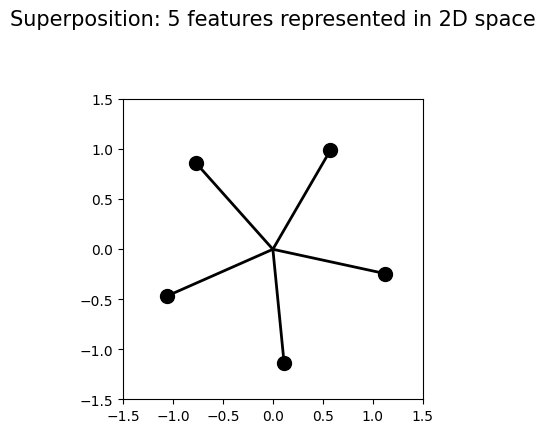

In [35]:
from dataclasses import dataclass
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from torch import nn, Tensor
import torch as t 
from tqdm import tqdm
import einops
from torch.nn import functional as F

device = "cpu"

def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0

class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    # def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
    #     '''
    #     Generates a batch of data. We'll return to this function later when we apply correlations.
    #     '''
    #     feat = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
    #     feat_seeds = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
    #     feat_is_present = feat_seeds <= self.feature_probability
    #     batch = t.where(
    #         feat_is_present,
    #         feat,
    #         t.zeros((), device=self.W.device),
    #     )
    #     return batch

    def generate_correlated_features(self, batch_size, n_correlated_pairs) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of correlated features.
        Each output[i, j, 2k] and output[i, j, 2k + 1] are correlated, i.e. one is present iff the other is present.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, 2 * n_correlated_pairs), device=self.W.device)
        feat_set_seeds = t.rand((batch_size, self.cfg.n_instances, n_correlated_pairs), device=self.W.device)
        feat_set_is_present = feat_set_seeds <= self.feature_probability[:, [0]]
        feat_is_present = einops.repeat(feat_set_is_present, "batch instances features -> batch instances (features pair)", pair=2)
        return t.where(feat_is_present, feat, 0.0)

    def generate_anticorrelated_features(self, batch_size, n_anticorrelated_pairs) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of anti-correlated features.
        Each output[i, j, 2k] and output[i, j, 2k + 1] are anti-correlated, i.e. one is present iff the other is absent.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, 2 * n_anticorrelated_pairs), device=self.W.device)
        feat_set_seeds = t.rand((batch_size, self.cfg.n_instances, n_anticorrelated_pairs), device=self.W.device)
        first_feat_seeds = t.rand((batch_size, self.cfg.n_instances, n_anticorrelated_pairs), device=self.W.device)
        feat_set_is_present = feat_set_seeds <= 2 * self.feature_probability[:, [0]]
        first_feat_is_present = first_feat_seeds <= 0.5
        first_feats = t.where(feat_set_is_present & first_feat_is_present, feat[:, :, :n_anticorrelated_pairs], 0.0)
        second_feats = t.where(feat_set_is_present & (~first_feat_is_present), feat[:, :, n_anticorrelated_pairs:], 0.0)
        return einops.rearrange(t.concat([first_feats, second_feats], dim=-1), "batch instances (pair features) -> batch instances (features pair)", pair=2)
    
    def generate_uncorrelated_features(self, batch_size, n_uncorrelated) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of uncorrelated features.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, n_uncorrelated), device=self.W.device)
        feat_seeds = t.rand((batch_size, self.cfg.n_instances, n_uncorrelated), device=self.W.device)
        feat_is_present = feat_seeds <= self.feature_probability[:, [0]]
        return t.where(feat_is_present, feat, 0.0)
    
    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data, with optional correlated & anticorrelated features.
        '''
        n_uncorrelated = self.cfg.n_features - 2 * self.cfg.n_correlated_pairs - 2 * self.cfg.n_anticorrelated_pairs
        data = []
        if self.cfg.n_correlated_pairs > 0:
            data.append(self.generate_correlated_features(batch_size, self.cfg.n_correlated_pairs))
        if self.cfg.n_anticorrelated_pairs > 0:
            data.append(self.generate_anticorrelated_features(batch_size, self.cfg.n_anticorrelated_pairs))
        if n_uncorrelated > 0:
            data.append(self.generate_uncorrelated_features(batch_size, n_uncorrelated))
        batch = t.cat(data, dim=-1)
        return batch




    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `model.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        '''
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
        return loss


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))
        
        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr
            
            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


cfg = Config(
    n_instances = 1,
    n_features = 5,
    n_hidden = 2,
)
model = Model(
    cfg = cfg,
    device = "cpu",
    feature_probability = 0.025,
)
model.optimize(steps=10_000)

plot_features_in_2d(
    values = model.W.detach(),
    title = "Superposition: 5 features represented in 2D space",
)

batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


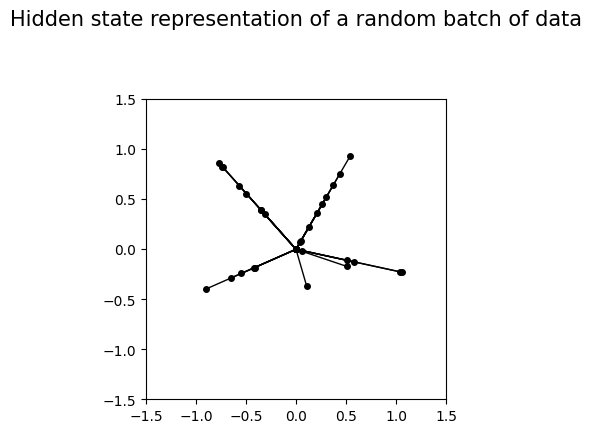

In [36]:
import torch as t
from torch import Tensor
from IPython.display import clear_output
from typing import List, Union, Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from typing import Tuple, List
from jaxtyping import Float
import einops

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider # , Button
from matplotlib.animation import FuncAnimation

Arr = np.ndarray


def plot_features_in_2d(
    values: Float[Tensor, "timesteps instances d_hidden feats"],
    colors = None, # shape [timesteps instances feats]
    title: Optional[str] = None,
    subplot_titles: Optional[List[str]] = None,
    save: Optional[str] = None,
    colab: bool = False,
):
    '''
    Visualises superposition in 2D.

    If values is 4D, the first dimension is assumed to be timesteps, and an animation is created.
    '''
    # Convert values to 4D for consistency
    if values.ndim == 3:
        values = values.unsqueeze(0)
    values = values.transpose(-1, -2)
    
    # Get dimensions
    n_timesteps, n_instances, n_features, _ = values.shape

    # If we have a large number of features per plot (i.e. we're plotting projections of data) then use smaller lines
    linewidth, markersize = (1, 4) if (n_features >= 25) else (2, 10)
    
    # Convert colors to 3D, if it's 2D (i.e. same colors for all instances)
    if isinstance(colors, list) and isinstance(colors[0], str):
        colors = [colors for _ in range(n_instances)]
    # Convert colors to something which has 4D, if it is 3D (i.e. same colors for all timesteps)
    if any([
        colors is None,
        isinstance(colors, list) and isinstance(colors[0], list) and isinstance(colors[0][0], str),
        (isinstance(colors, Tensor) or isinstance(colors, Arr)) and colors.ndim == 3,
    ]):
        colors = [colors for _ in range(values.shape[0])]
    # Now that colors has length `timesteps` in some sense, we can convert it to lists of strings
    colors = [parse_colors_for_superposition_plot(c, n_instances, n_features) for c in colors]

    # Same for subplot titles & titles
    if subplot_titles is not None:
        if isinstance(subplot_titles, list) and isinstance(subplot_titles[0], str):
            subplot_titles = [subplot_titles for _ in range(values.shape[0])]
    if title is not None:
        if isinstance(title, str):
            title = [title for _ in range(values.shape[0])]

    # Create a figure and axes
    fig, axs = plt.subplots(1, n_instances, figsize=(5 * n_instances, 5))
    if n_instances == 1:
        axs = [axs]
    
    # If there are titles, add more spacing for them
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)
    if title:
        fig.subplots_adjust(top=0.8)
    # Initialize lines and markers
    lines = []
    markers = []
    for instance_idx, ax in enumerate(axs):
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal', adjustable='box')
        instance_lines = []
        instance_markers = []
        for feature_idx in range(n_features):
            line, = ax.plot([], [], color=colors[0][instance_idx][feature_idx], lw=linewidth)
            marker, = ax.plot([], [], color=colors[0][instance_idx][feature_idx], marker='o', markersize=markersize)
            instance_lines.append(line)
            instance_markers.append(marker)
        lines.append(instance_lines)
        markers.append(instance_markers)

    def update(val):
        # I think this doesn't work unless I at least reference the nonlocal slider object
        # It works if I use t = int(val), so long as I put something like X = slider.val first. Idk why!
        if n_timesteps > 1:
            _ = slider.val
        t = int(val) 
        for instance_idx in range(n_instances):
            for feature_idx in range(n_features):
                x, y = values[t, instance_idx, feature_idx].tolist()
                lines[instance_idx][feature_idx].set_data([0, x], [0, y])
                markers[instance_idx][feature_idx].set_data(x, y)
                lines[instance_idx][feature_idx].set_color(colors[t][instance_idx][feature_idx])
                markers[instance_idx][feature_idx].set_color(colors[t][instance_idx][feature_idx])
            if title:
                fig.suptitle(title[t], fontsize=15)
            if subplot_titles:
                axs[instance_idx].set_title(subplot_titles[t][instance_idx], fontsize=12)
        fig.canvas.draw_idle()
    def play(event):
        _ = slider.val
        for i in range(n_timesteps):
            update(i)
            slider.set_val(i)
            plt.pause(0.05)
        fig.canvas.draw_idle()

    if n_timesteps > 1:
        # Create the slider
        ax_slider = plt.axes([0.15, 0.05, 0.7, 0.05], facecolor='lightgray')
        slider = Slider(ax_slider, 'Time', 0, n_timesteps - 1, valinit=0, valfmt='%1.0f')

        # Create the play button
        # ax_button = plt.axes([0.8, 0.05, 0.08, 0.05], facecolor='lightgray')
        # button = Button(ax_button, 'Play')

        # Call the update function when the slider value is changed / button is clicked
        slider.on_changed(update)
        # button.on_clicked(play)

        # Initialize the plot
        play(0)
    else:
        update(0)

    # Save
    if isinstance(save, str):
        ani = FuncAnimation(fig, update, frames=n_timesteps, interval=0.04, repeat=False)
        ani.save(save, writer='pillow', fps=25)
    elif colab:
        ani = FuncAnimation(fig, update, frames=n_timesteps, interval=0.04, repeat=False)
        clear_output()
        return ani
    


def parse_colors_for_superposition_plot(
    colors: Optional[Union[Tuple[int, int], Float[Tensor, "instances feats"]]],
    n_instances: int,
    n_feats: int,
) -> List[List[str]]:
    '''
    There are lots of different ways colors can be represented in the superposition plot.
    
    This function unifies them all by turning colors into a list of lists of strings, i.e. one color for each instance & feature.
    '''
    # If colors is a tensor, we assume it's the importances tensor, and we color according to a viridis color scheme
    if isinstance(colors, Tensor):
        colors = t.broadcast_to(colors, (n_instances, n_feats))
        colors = [
            [helper_get_viridis(v.item()) for v in colors_for_this_instance]
            for colors_for_this_instance in colors
        ]
    
    # If colors is a tuple of ints, it's interpreted as number of correlated / anticorrelated pairs
    elif isinstance(colors, tuple):
        n_corr, n_anti = colors
        n_indep = n_feats - 2 * (n_corr - n_anti)
        colors = [
            ["blue", "blue", "limegreen", "limegreen", "purple", "purple"][:n_corr*2] + ["red", "red", "orange", "orange", "brown", "brown"][:n_anti*2] + ["black"] * n_indep
            for _ in range(n_instances)
        ]
    
    # If colors is a string, make all datapoints that color
    elif isinstance(colors, str):
        colors = [[colors] * n_feats] * n_instances
    
    # Lastly, if colors is None, make all datapoints black
    elif colors is None:
        colors = [["black"] * n_feats] * n_instances
    
    return colors



plot_features_in_2d(
    values = hidden,
    title = "Hidden state representation of a random batch of data",
)


Train the SAE

In [37]:
from torch.distributions.categorical import Categorical

@dataclass
class AutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    l1_coeff: float = 1.0
    tied_weights: bool = False


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: AutoEncoderConfig):
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))
        self.to(device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).sum(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum() # scalar
        
        return l1_loss, l2_loss, loss, acts, h_reconstructed
    
    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm. If using tied weights, we we assume W_enc is used for both.
        '''
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        _, l2_loss, _, _, _ = self.forward(h)

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_neurons_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_neurons_mask[instance] = is_dead
            dead_neurons = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_neurons.numel()
            if n_dead == 0: continue
            
            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance] # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue # If we have zero reconstruction loss, we don't need to resample neurons
            
            # Draw `n_hidden_ae` samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance / l2_loss_instance.sum())
            replacement_indices = distn.sample((n_dead,)) # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance] # shape [n_dead n_input_ae]

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()
            
            # Use this to renormalize the replacement values
            replacement_values = (replacement_values / (replacement_values.norm(dim=1, keepdim=True) + 1e-8)) * W_enc_norm_alive_mean * neuron_resample_scale

            # Lastly, set the new weights & biases
            self.W_enc.data[instance, :, dead_neurons] = replacement_values.T
            self.b_enc.data[instance, dead_neurons] = 0.0

        # Return data for visualising the resampling process
        colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_neurons_mask]
        title = f"resampling {dead_neurons_mask.sum().item()}/{dead_neurons_mask.numel()} neurons (shown in red)"
        return colors, title

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))
        
        # Create lists to store data we'll eventually be plotting
        data_log = {"values": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")
            
            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()
            
            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["values"].append(self.W_enc.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log
    
ae_cfg = AutoEncoderConfig(
    n_instances = 1,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.5,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
)

100%|██████████| 36000/36000 [00:18<00:00, 1929.09it/s, l1_loss=0.0434, l2_loss=0.00963, lr=0.001]


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


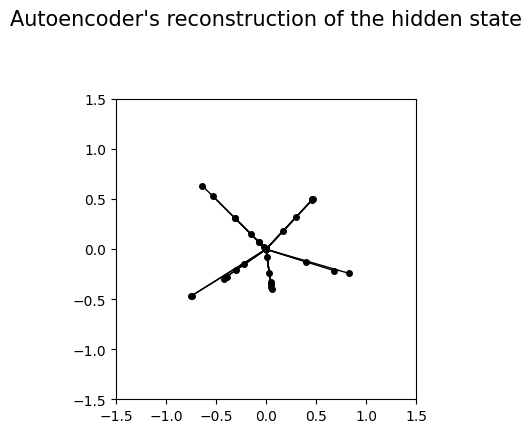

In [38]:
# Now check the points are being reconstructed faithfully by our autoencoder
batch = model.generate_batch(250)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed = autoencoder.forward(hidden)[-1]

plot_features_in_2d(
    values = einops.rearrange(hidden_reconstructed, "batch_size instances hidden -> instances hidden batch_size"),
    title = "Autoencoder's reconstruction of the hidden state",
)


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_5713/1676659791.py:101: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  markers[instance_idx][feature_idx].set_data(x, y)


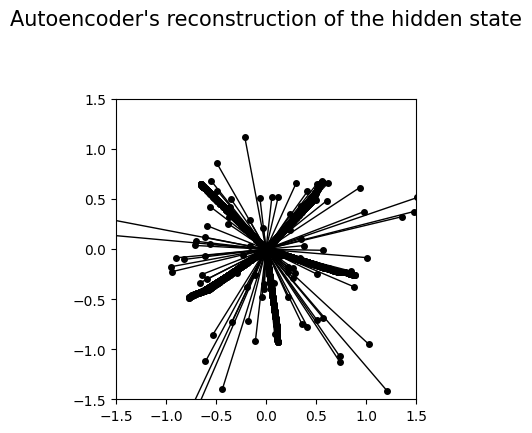

In [43]:
# Now check the points are being reconstructed faithfully by our autoencoder
batch = model.generate_batch(25000)
hidden = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed = autoencoder.forward(hidden)[-1]

plot_features_in_2d(
    values = einops.rearrange(hidden_reconstructed, "batch_size instances hidden -> instances hidden batch_size"),
    title = "Autoencoder's reconstruction of the hidden state",
)

In [44]:
batch.shape

torch.Size([25000, 1, 5])

In [45]:
hidden.shape

torch.Size([25000, 1, 2])

In [47]:
from src.SAE import SAE
from src.train_sae import train_sae

sae_cfg = {
    "d_in": 2,
    "d_sae": 5,
    "dtype": t.float32,
    "device": "cpu",
}

sae = SAE(sae_cfg)

sae.train()

wandb.finish()
wandb.init()
train_sae(sae, hidden.detach().squeeze(), use_wandb=True)
wandb.finish()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


l0,▂▁▂▁▁▇▇▇███████▇██▇█▇█▇▇▇█▇▇▇▇▇▇███▇▇▇▇█
l1_loss,▁▁▁▁▁▂▃▄▅▄▅▆▆▆▆▆▇▇▇█▇█▇█▇█▇▇▇██████▇▇█▇█
l2,▂▁▁▁▁▂▃▄▅▅▅▆▆▆▆▆▇▇▇█▇█▇█▇█▇▇▇██████▇▇███
loss,█▂▁▂▁▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_loss,█▂▁▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_dead_features,▁▁▃▁▃▆█▃▆▆▆▆██▆▆▆▆█▆█▆██████████████████
l0,2.0
l1_loss,9.11829
l2,0.80605
loss,0.00092
mse_loss,1e-05
